In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt

# from evaluate import *
from load_test_set_pytorch import *
from load_dataset_rgb_scale import *
from __future__ import print_function
from torch.autograd import Variable

numClass = 43

In [2]:
X, Y = get_dataset_rgb_scale()
print(X.shape)
print(Y.shape)

(39209, 64, 64, 3)
(39209,)


In [3]:
def transpose_dimension(x):
    x = np.transpose(x, (0, 3, 1, 2))
    return x

In [4]:
X = transpose_dimension(X)
print(X.shape)

(39209, 3, 64, 64)


In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #using "same" 2 times with relu then max pool from 64x64x3 to 32x32x9
        self.conv1 = nn.Conv2d(3, 6, 9, padding=4) 
        self.conv2 = nn.Conv2d(6, 9, 9, padding=4) 
        #using "same" 2 times with relu then max pool from 32x32x9 to 16x16x15
        self.conv3 = nn.Conv2d(9, 12, 7, padding=3) 
        self.conv4 = nn.Conv2d(12, 15, 7, padding=3) 
        #using "same" 2 times with relu then max pool from 16x16x15 to 8x8x21
        self.conv5 = nn.Conv2d(15, 18, 5, padding=2) 
        self.conv6 = nn.Conv2d(18, 21, 5, padding=2) 
        #using "same" with maxpool with relu from 8x8x21 to 8x8x27 then to 4x4x27
        self.conv7 = nn.Conv2d(21, 24, 3, padding=1)
        self.conv8 = nn.Conv2d(24, 27, 3, padding=1)

        #Fully connected layer
        self.fc1 = nn.Linear(432, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(64, 43)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(F.relu(self.conv2(X)), (2,2))
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(F.relu(self.conv4(X)), (2,2))
        X = F.relu(self.conv5(X))
        X = F.max_pool2d(F.relu(self.conv6(X)), (2,2))
        X = F.relu(self.conv7(X))
        X = F.max_pool2d(F.relu(self.conv8(X)), (2,2))
    
        X = X.view(-1, self.num_flat_features(X))
        
        X1 = F.relu(self.fc1(X)) #432 to 300
        X2 = F.relu(self.fc2(X1)) #300 to 200
        X3 = F.relu(self.fc3(X2)) #200 to 200
        X4 = F.relu(self.fc4(X2 + X3)) #200 to 128
        X5 = F.relu(self.fc5(X4)) #128 to 128
        X6 = F.relu(self.fc6(X5 + X4)) #128 to 64
        X7 = F.relu(self.fc7(X6)) #64 to 64
        X8 = F.relu(self.fc8(X6 + X7)) #64 to 64
        X9 = self.fc9(X8)

        return X
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [17]:
def train_data(checkpoint_path, store_type,
               learning_rate = (1e-4), num_epochs = 5, batch_size = 64, resume = False, num_class = 43):
    net = Net()
    start = time.time()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    m = X.shape[0]
    iters_per_epoch = int(m / batch_size)+1
    hist = []
    
    name_checkpoint = "model_epoch" + store_type + ".chkpt"
    
    if (resume):
        checkpoint = torch.load(os.path.join(checkpoint_path, name_checkpoint))
        hist = checkpoint["hist"]
        optimizer.load_state_dict(checkpoint["optimizer"])
        net.load_state_dict(checkpoint["net"])
    
    cnt = 0
    for param_group in optimizer.param_groups: 
        param_group['lr'] = learning_rate
        cnt += 1
    print(cnt)
    
    for iters in range(num_epochs):
        for i in range(iters_per_epoch):
            indices = np.random.choice(m, batch_size)
#             print()
            
            input = X[indices]
            target = Y[indices]
            
            input = Variable(torch.from_numpy(input).float())
            target = Variable(torch.from_numpy(target).long())
            
            out = net(input)
            loss = criterion(out, target)
            
            optimizer.zero_grad()
            net.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i%40==0):
                now = time.time()
                print("iterate %d: loss = %.9f, spent = %.5f" % (i + 1, loss.data[0], now - start))
                start = now

        print("Epoch %d: loss = %.9f" % (iters + 1, loss.data[0]))
        hist.append(loss.data[0])
        
    #
    
    optimizer.zero_grad()
    checkpoint = {
        "optimizer": optimizer.state_dict(),
        "hist": hist,
        "net": net.state_dict()
    }
    torch.save(checkpoint, os.path.join(checkpoint_path, name_checkpoint))
    
    return hist

In [18]:
hist = train_data("checkpoint", "11", resume = True, num_epochs = 3)

1
iterate 1: loss = 0.188046709, spent = 0.91788
iterate 41: loss = 0.098726459, spent = 35.50823
iterate 81: loss = 0.119357526, spent = 35.79569
iterate 121: loss = 0.233187169, spent = 36.46851
iterate 161: loss = 0.180718467, spent = 36.88355
iterate 201: loss = 0.275977582, spent = 36.54720
iterate 241: loss = 0.156635270, spent = 36.71249
iterate 281: loss = 0.148248583, spent = 36.91655
iterate 321: loss = 0.237905934, spent = 36.56615
iterate 361: loss = 0.191249534, spent = 38.49671
iterate 401: loss = 0.080186568, spent = 36.03751
iterate 441: loss = 0.118834272, spent = 36.08990
iterate 481: loss = 0.217800215, spent = 37.54166
iterate 521: loss = 0.086915031, spent = 36.34997
iterate 561: loss = 0.207074717, spent = 36.67723
iterate 601: loss = 0.085938543, spent = 36.46018
Epoch 1: loss = 0.070142679
iterate 1: loss = 0.139630467, spent = 11.92226
iterate 41: loss = 0.075974613, spent = 36.34908
iterate 81: loss = 0.136316538, spent = 36.72448
iterate 121: loss = 0.0967417

In [19]:
checkpoint = torch.load(os.path.join("checkpoint", "model_epoch11.chkpt"))

net = Net()

hist = checkpoint["hist"]
net.load_state_dict(checkpoint["net"])

print(hist)
print(len(hist))
print(net)

[2.5182900428771973, 1.5142749547958374, 1.1461366415023804, 0.6217596530914307, 0.49422958493232727, 0.4902268946170807, 0.22011202573776245, 0.20778802037239075, 0.07014267891645432, 0.12256475538015366, 0.07771004736423492]
11
Net(
  (conv1): Conv2d (3, 6, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d (6, 9, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d (9, 12, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv4): Conv2d (12, 15, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv5): Conv2d (15, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d (18, 21, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv7): Conv2d (21, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d (24, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=432, out_features=300)
  (fc2): Linear(in_features=300, out_features=200)
  (fc3): Linear(in_features=200, out_feature

In [9]:
test_X, test_Y = load_test_set()
print(test_X.shape)
print(test_Y.shape)

(12630, 64, 64, 3)
(12630,)


In [ ]:
print(Sh)

In [10]:
test_X = transpose_dimension(test_X)
print(test_X.shape)
print(test_X[0].shape)

(12630, 3, 64, 64)
(3, 64, 64)


In [11]:
def get_outputs(net, instances):
    instances = Variable(instances)
    outputs = net(instances)
    return outputs

def evaluate(net, data_X, data_Y):
    loss = 0
    correct = 0
    total = 0
    
    m = data_X.shape[0]

    # Switch to evaluation mode.
    net.eval()
    
    for i in range(m):
        outputs = get_outputs(net, torch.from_numpy(data_X[i:i+1]).float())
        labels = Variable(torch.from_numpy(data_Y[i:i+1]).long())

        loss += nn.CrossEntropyLoss(size_average=False)(outputs, labels).data[0]

        score, predicted = torch.max(outputs, 1)
        now = (labels.data == predicted.data).sum()
        correct += now
        
#         if (now==0):
#             print(i)
            
        total += labels.size(0)

    acc = correct / total
    loss /= total

    return loss, acc


In [13]:
start = time.time()
loss, acc = evaluate(net, test_X, test_Y)
now = time.time()

print("Loss = %.6f" % (loss))
print("Acc = %.6f percent" % (acc*100))
print("Time per image: %.6f seconds: " % ((now-start)/test_X.shape[0]))

Loss = 1.188574
Acc = 66.033254 percent
Time per image: 0.007712 seconds: 


In [ ]:
loss, acc = evaluate(net, X, Y)

print("Loss = %.6f" % (loss))
print("Acc = %.6f percent" % (acc*100))

[2.5182900428771973, 1.5142749547958374, 1.1461366415023804, 0.6217596530914307, 0.49422958493232727, 0.4902268946170807, 0.22011202573776245, 0.20778802037239075, 0.07014267891645432, 0.12256475538015366, 0.07771004736423492]


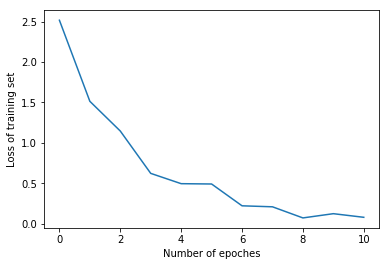

Test set loss = 0.646080
Test set acc = 86.104513 percent
Time per image: 0.009311 seconds: 


In [ ]:
print(hist)
plt.plot(hist)
plt.ylabel('Loss of training set')
plt.xlabel('Number of epoches')
plt.show()

start = time.time()
loss, acc = evaluate(net, test_X, test_Y)
now = time.time()
print("Test set loss = %.6f" % (loss))
print("Test set acc = %.6f percent" % (acc*100))
print("Time per image: %.6f seconds: " % ((now-start)/test_X.shape[0]))

start = time.time()
loss, acc = evaluate(net, X, Y)
now = time.time()
print("Train set loss = %.6f" % (loss))
print("Train set acc = %.6f percent" % (acc*100))
print("Time per image: %.6f seconds: " % ((now-start)/X.shape[0]))


In [ ]:
print(hist)
plt.plot(hist)
plt.ylabel('Loss of training set')
plt.xlabel('Number of epoches')
plt.show()

start = time.time()
loss, acc = evaluate(net, test_X, test_Y)
now = time.time()
print("Test set loss = %.6f" % (loss))
print("Test set acc = %.6f percent" % (acc*100))
print("Time per image: %.6f seconds " % ((now-start)/test_X.shape[0]))

start = time.time()
loss, acc = evaluate(net, X, Y)
now = time.time()
print("Train set loss = %.6f" % (loss))
print("Train set acc = %.6f percent" % (acc*100))
print("Time per image: %.6f seconds " % ((now-start)/X.shape[0]))
